# Lab: Explainability in Neural Networks with activation maximization.

***Students : Álvaro Alcalde Cid, Felipe Guzmán Rodríguez and Rubén Ribes Serrano***
------------------------------------------------------
*Alex Guerrero (Lab instructor): alexjorguer@tsc.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
------------------------------------------------------

In this part of the lab, we will implement a simple example of **activation maximization** to find out wich patterns are neccesary at the input of a neural network, that has been previously trained, to get a desired output (for example, a high confidence in a classification task).

We will visualize this technique using MNIST database.

In [109]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [110]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://i1.wp.com/datasmarts.net/es/wp-content/uploads/2019/09/1_yBdJCRwIJGoM7pwU-LNW6Q.png?w=479&ssl=1", width=400, height=200)

Load the dataset with torchvision ...

In [111]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.,), (1.0,)), # Media 0, varianza 1
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [112]:
dataiter = iter(trainloader)   # To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Let's show some image from that batch ...

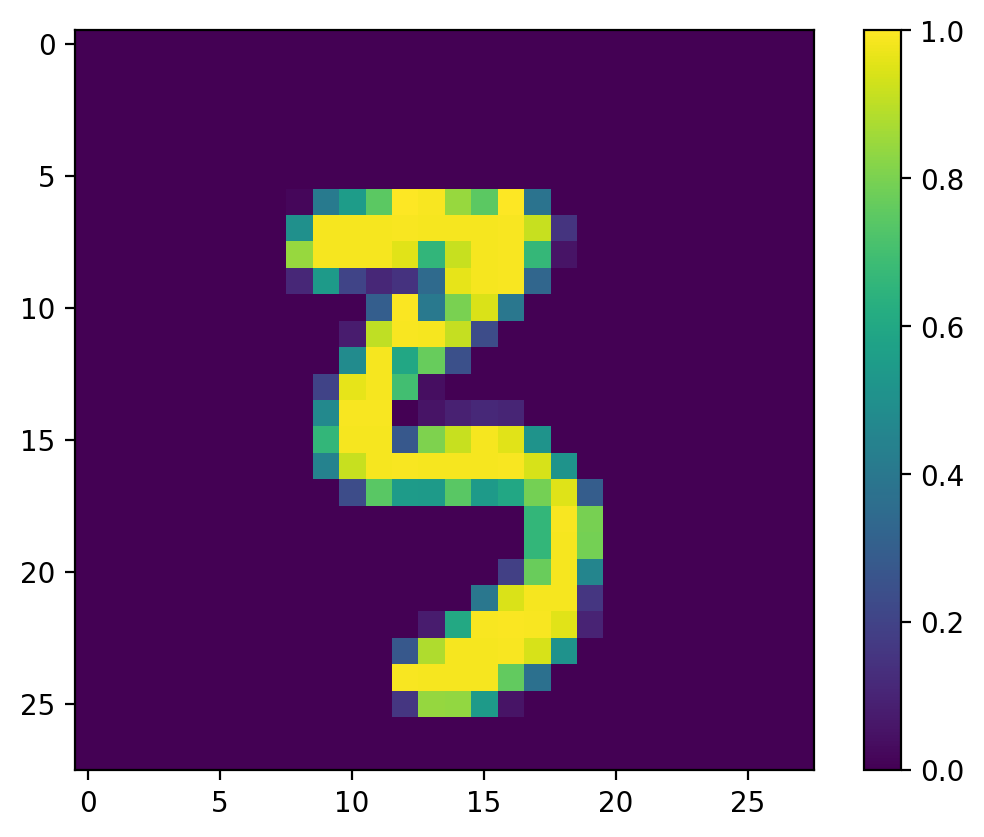

In [113]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

We also create a validation set.

In [114]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise:** Train an MLP network based on four dense layers of 256, 128, 64 and 10 hidden units respectively. Calculate the accuracy in training and test sets after training only 3 epochs. If you notice overfitting problems, introduce whatever mechanisms you consider to reduce it.

In [115]:
# YOUR CODE HERE
class MLP(nn.Module):

    def __init__(self,dimx, hidden1, hidden2, hidden3, nlabels, dropout = 0.2):
        super().__init__()
        self.output1 = nn.Linear(dimx, hidden1)
        self.output2 = nn.Linear(hidden1, hidden2)
        self.output3 = nn.Linear(hidden2, hidden3)
        self.output4 = nn.Linear(hidden3, nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        self.dropout = nn.Dropout(p = dropout)
    
    def forward(self, x):
        
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

class MLP_extended(MLP):
    
    
    def __init__(self,dimx, hidden1, hidden2, hidden3, nlabels, epochs = 100,lr = 0.001, dropout = 0.2):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels, dropout)
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), lr = self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()
        
        self.loss_during_training = []
        self.valid_loss_during_training = []
    
    def trainloop(self,trainloader,validloader = None):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                self.train() # To activate the dropout
                
                self.optim.zero_grad()
                
                out = self.forward(images.view(images.shape[0],-1))
                
                loss = self.criterion(out, labels)
                
                running_loss += loss.item()
                
                loss.backward()
                
                self.optim.step()
    
            self.loss_during_training.append(running_loss/len(trainloader))
            if validloader is not None:
                
                self.eval() # To deactivate the dropout
                
                valid_loss = 0.
                with torch.no_grad():
                    for images, labels in validloader:
                        out = self.forward(images.view(images.shape[0],-1))
                        loss = self.criterion(out, labels)
                        valid_loss += loss.item()
                self.valid_loss_during_training.append(valid_loss/len(validloader))
                if (e % 1 == 0):
                    print(f'-- Epoch {e+1}/{self.epochs}: Training loss: {self.loss_during_training[-1]}, Validation loss: {self.valid_loss_during_training[-1]}')
            else:
                if (e % 1 == 0):
                    print(f'-- Epoch {e+1}/{self.epoch}: Training loss: {self.loss_during_training[-1]}')

    def evaluate(self,dataloader):
        accuracy = 0
        with torch.no_grad():
            for images,labels in dataloader:
                
                logprobs = self.forward(images.view(images.shape[0], -1))
                
                _, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            

        print("Accuracy %f" %(accuracy/len(dataloader)))
                    


In [116]:
dropout = 0.2
my_MLP_drop = MLP_extended(784, 256, 128, 64, 10, epochs = 3, lr = 0.001, dropout = dropout)

my_MLP_drop.trainloop(trainloader,validloader)

print('-- Training set --')
my_MLP_drop.evaluate(trainloader)
print('-- Test set --')
my_MLP_drop.evaluate(testloader)


-- Epoch 1/3: Training loss: 0.3960110943192955, Validation loss: 0.16287166861460564
-- Epoch 2/3: Training loss: 0.1508684083396061, Validation loss: 0.12694582141975455
-- Epoch 3/3: Training loss: 0.10769749481947986, Validation loss: 0.1003926237584389
-- Training set --
Accuracy 0.983398
-- Test set --
Accuracy 0.973826


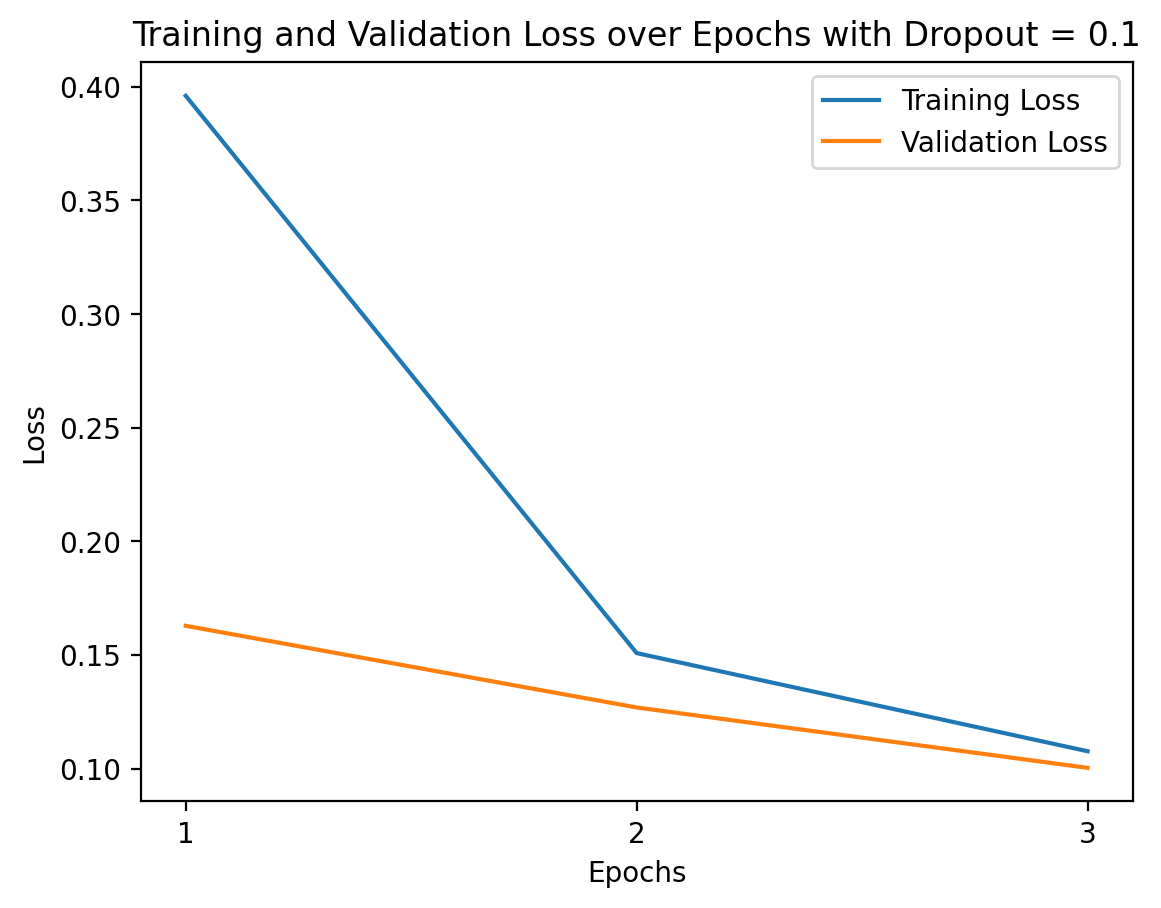

In [117]:
epochs = len(my_MLP_drop.loss_during_training)
x_values = np.arange(1, epochs + 1)
plt.plot(x_values, my_MLP_drop.loss_during_training, label="Training Loss")
plt.plot(x_values, my_MLP_drop.valid_loss_during_training, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss over Epochs with Dropout = {dropout}")
plt.xticks(x_values)
plt.legend()
plt.show()

**Mechanisms applied**: As we learnt at the previous labs, at the previous neural net, we applied the dropout technique with different values and we considered that with a dropout value of 0.2, we obtain a great performance of the net.

## Activation Maximization

Once our network has been trained, the goal is to find which features at the input of the network (pixels in our case) are more important for the classifier to decide one class or another at the output. That is, choose between one digit or another at the output. 

The steps we follow are the following:

- We fix the parameters that we have just trained.

- We define a new set of trainable parameters that will emulate the input of the network and we will opbtimize to have a high confidence in a specific digit.

We implement the first step with the following code:

In [118]:
for param in my_MLP_drop.parameters(): #my_MLP_drop is the name of your neural network!
    param.requires_grad = False

> **Exercise:** Complete the following code, in which we define the optimization problem to find the image at the input of the network that provides a given confidence in a given digit

In [119]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,NN_trained,lr,img0): 
      
        # NN_trained is the trained network, as argument

        # img0 is a radomn initialization for the input image
        
        super().__init__()
        
        # Self.input --> Image to be optimized

        self.input = nn.Parameter(img0.reshape([1,-1]), requires_grad = True)

        self.NN_trained = NN_trained

        self.lr = lr
        
        # We use mean squared error to minimize the difference between the desired probability and the 
        # obtained for self.input to input

        self.criterion = nn.MSELoss() 

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

    def forward(self):

        # In the forward method we only evaluate the log-probabilities given self.input!

        logprobs = self.NN_trained.forward(self.input) #YOUR CODE HERE)
        
        return logprobs

    def trainloop(self,category,true_prob,sgd_iter):

        # Category is the digit we are going to look at

        # true_prob is the desired probability, which we pass to logarithm
        
        true_log_prob = torch.log(true_prob) #YOUR CODE HERE)

        # sgd_iter is the number of iterations
        
        for i in range(sgd_iter):

            # Reset the gradients
            self.optim.zero_grad() #YOUR CODE HERE 
            
            # Compute the network output
            logprobs = self.forward() #YOUR CODE HERE
            
            # We calculate the difference between the desired probability (true_log_prob) and the obtained one
            # for the digit
            
            loss = self.criterion(logprobs[0,category].view(true_log_prob.shape),true_log_prob) #YOUR CODE HERE)
  

            self.loss_during_training.append(loss)

            # Compute gradients
            loss.backward() #YOUR CODE HERE
          
            # Optimize
            self.optim.step() #YOUR CODE HERE

Let's instanciate an object of the previous class for a random initialization (independent Gaussian distribution with mean zero and standard deviation 0.01)

In [120]:
opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01)

> **Exercise:** Obtain the probability distribution at the output of the classifier for the chosen initialization. Remember that the classifier uses a `logsoftmax` on output. Discuss the result.

**ANSWER:**

In [121]:
#YOUR CODE HERE

log_probs_before_train = opt_input.forward()

probs_before_train = torch.exp(log_probs_before_train)

for i, prob_before in enumerate(probs_before_train[0]):
    print(f"Probability of being digit {i}: {prob_before.item():.4f}")

Probability of being digit 0: 0.0583
Probability of being digit 1: 0.1128
Probability of being digit 2: 0.0601
Probability of being digit 3: 0.0671
Probability of being digit 4: 0.1308
Probability of being digit 5: 0.2152
Probability of being digit 6: 0.0778
Probability of being digit 7: 0.0964
Probability of being digit 8: 0.0746
Probability of being digit 9: 0.1070


> **Exercise:**: Optimize the input representation for 50 iterations to obtain 90% confidence in the digit 3. Plot the loss function.

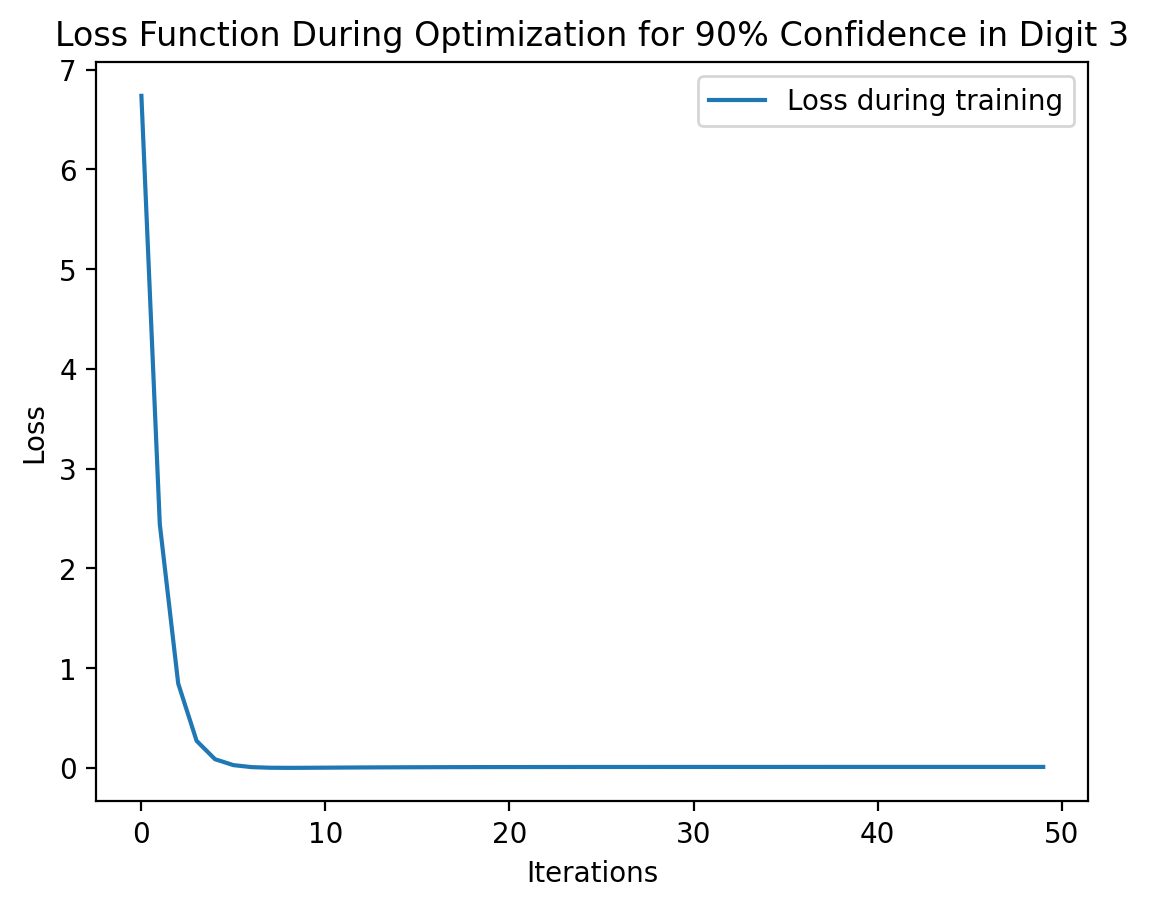

Probability of being digit 3: 0.9922


In [122]:
#YOUR CODE HERE

opt_input.trainloop(category=3, true_prob=torch.tensor([0.9]), sgd_iter=50)

log_probs = opt_input.forward()
probs = torch.exp(log_probs)

plt.plot([loss.item() for loss in opt_input.loss_during_training], label="Loss during training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Loss Function During Optimization for 90% Confidence in Digit 3")
plt.legend()
plt.show()

print(f"Probability of being digit 3: {probs[0, 3].item():.4f}")

> **Exercise:** Compare the probabilities at the output of the classifier before and after optimizing at the input

In [123]:
#YOUR CODE HERE

print(f"{' ':>25} {'Before':>10} {' ':>3} {'After'}")
for i, (prob_before,prob_after) in enumerate(zip(probs_before_train[0],probs[0])):
    print(f"Probability of being digit {i}: {prob_before.item():.4f} -> {prob_after.item():.4f}")

                              Before     After
Probability of being digit 0: 0.0583 -> 0.0000
Probability of being digit 1: 0.1128 -> 0.0045
Probability of being digit 2: 0.0601 -> 0.0006
Probability of being digit 3: 0.0671 -> 0.9922
Probability of being digit 4: 0.1308 -> 0.0000
Probability of being digit 5: 0.2152 -> 0.0015
Probability of being digit 6: 0.0778 -> 0.0000
Probability of being digit 7: 0.0964 -> 0.0008
Probability of being digit 8: 0.0746 -> 0.0001
Probability of being digit 9: 0.1070 -> 0.0002


> **Exercise:** Display the optimized input image. Does it roughly match the expected digit? Discuss the results.

**ANSWER:**

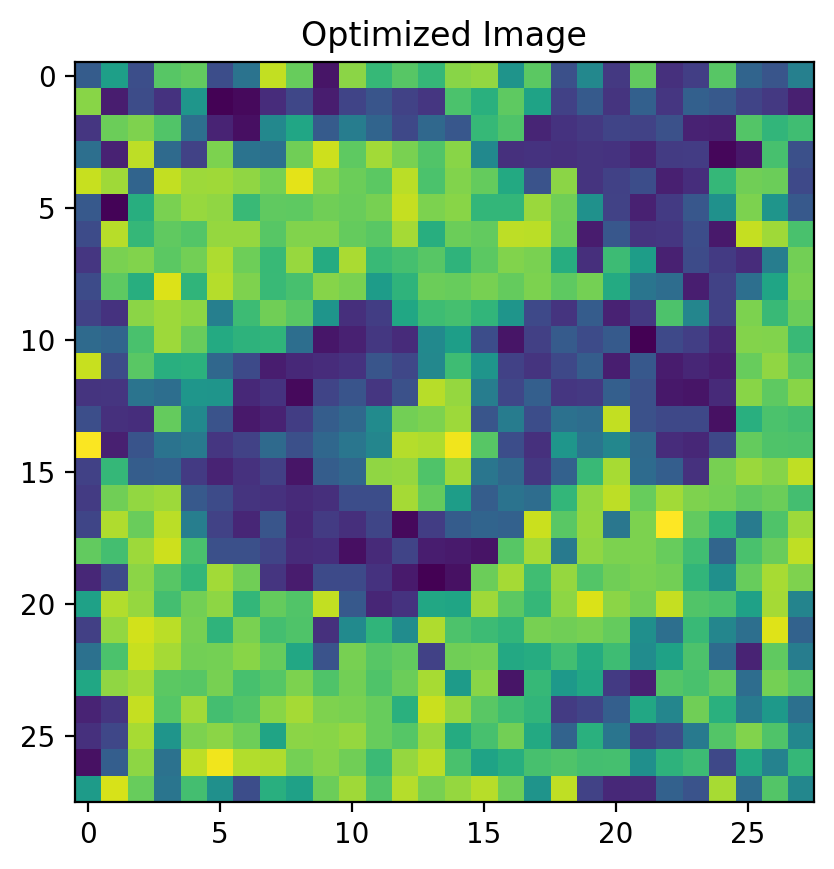

In [124]:
#YOUR CODE HERE
optimized_image = opt_input.input.detach().numpy().reshape(28, 28)

plt.imshow(optimized_image, cmap='viridis')
plt.title("Optimized Image")
plt.show()


> **Exercise:** Repeat the results for all digits and discuss those results.

**ANSWER:**

                              Before     After
Probability of being digit 0: 0.0620 -> 0.9746
Probability of being digit 1: 0.0958 -> 0.0001
Probability of being digit 2: 0.0504 -> 0.0050
Probability of being digit 3: 0.0615 -> 0.0003
Probability of being digit 4: 0.1358 -> 0.0005
Probability of being digit 5: 0.2088 -> 0.0035
Probability of being digit 6: 0.0714 -> 0.0052
Probability of being digit 7: 0.1008 -> 0.0034
Probability of being digit 8: 0.0805 -> 0.0007
Probability of being digit 9: 0.1330 -> 0.0068


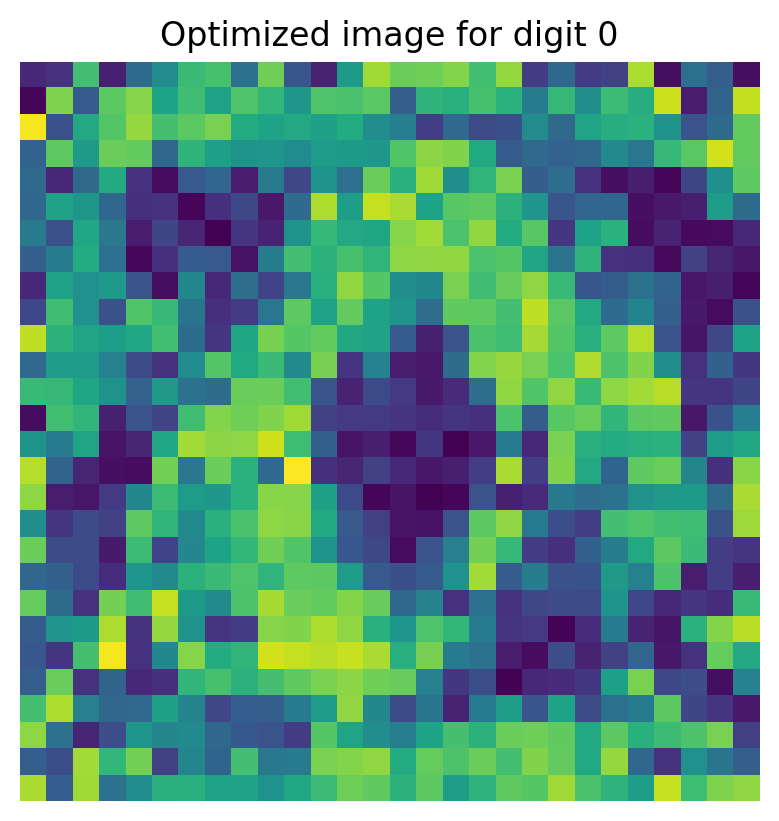

                              Before     After
Probability of being digit 0: 0.0660 -> 0.0000
Probability of being digit 1: 0.0967 -> 0.9938
Probability of being digit 2: 0.0562 -> 0.0011
Probability of being digit 3: 0.0673 -> 0.0018
Probability of being digit 4: 0.1046 -> 0.0002
Probability of being digit 5: 0.2425 -> 0.0013
Probability of being digit 6: 0.0665 -> 0.0003
Probability of being digit 7: 0.1090 -> 0.0010
Probability of being digit 8: 0.0782 -> 0.0004
Probability of being digit 9: 0.1129 -> 0.0001


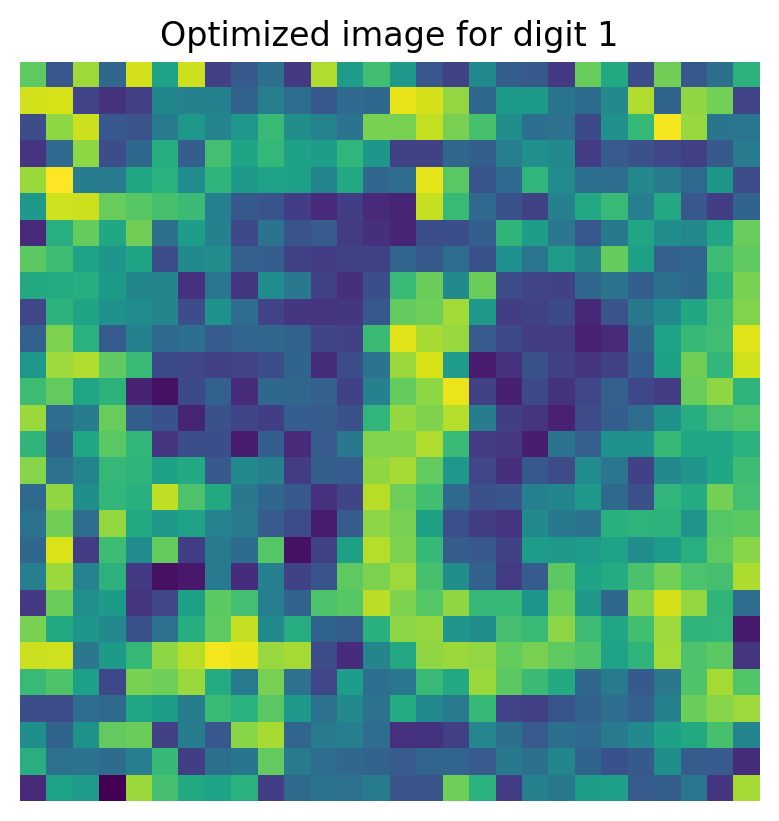

                              Before     After
Probability of being digit 0: 0.0692 -> 0.0000
Probability of being digit 1: 0.0970 -> 0.0026
Probability of being digit 2: 0.0590 -> 0.9916
Probability of being digit 3: 0.0504 -> 0.0030
Probability of being digit 4: 0.1450 -> 0.0000
Probability of being digit 5: 0.1910 -> 0.0000
Probability of being digit 6: 0.0789 -> 0.0002
Probability of being digit 7: 0.1220 -> 0.0022
Probability of being digit 8: 0.0765 -> 0.0003
Probability of being digit 9: 0.1110 -> 0.0000


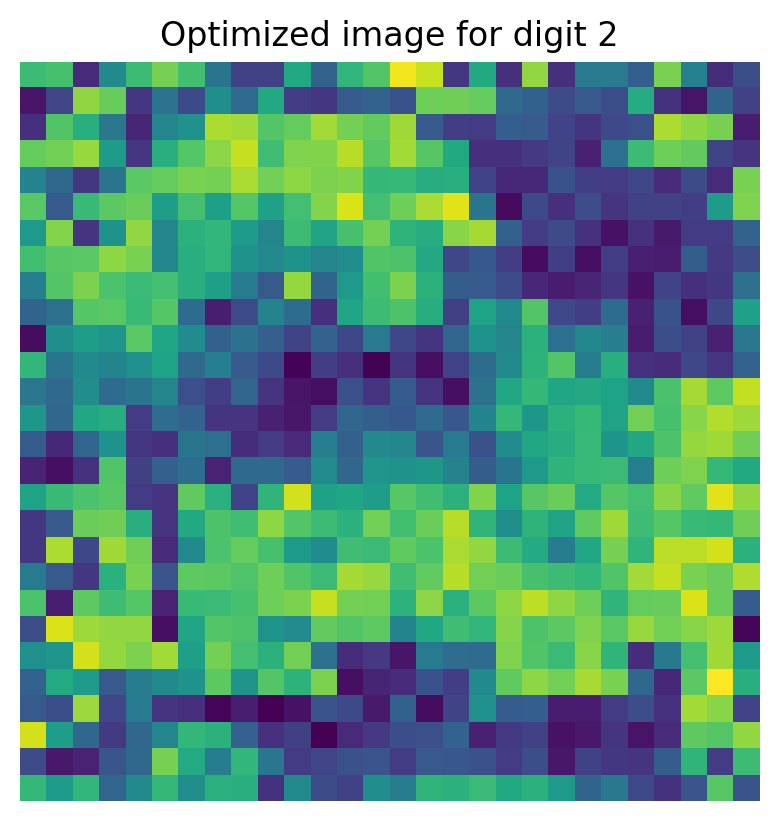

                              Before     After
Probability of being digit 0: 0.0618 -> 0.0000
Probability of being digit 1: 0.1098 -> 0.0043
Probability of being digit 2: 0.0606 -> 0.0007
Probability of being digit 3: 0.0470 -> 0.9925
Probability of being digit 4: 0.1599 -> 0.0000
Probability of being digit 5: 0.2001 -> 0.0015
Probability of being digit 6: 0.1079 -> 0.0000
Probability of being digit 7: 0.0947 -> 0.0007
Probability of being digit 8: 0.0770 -> 0.0001
Probability of being digit 9: 0.0811 -> 0.0002


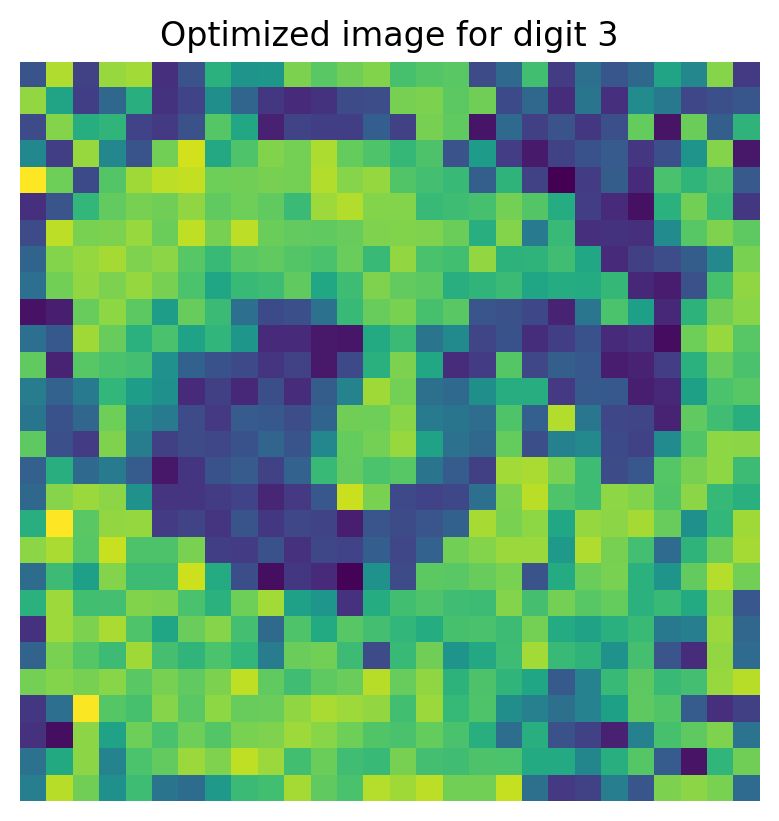

                              Before     After
Probability of being digit 0: 0.0671 -> 0.0001
Probability of being digit 1: 0.1153 -> 0.0005
Probability of being digit 2: 0.0747 -> 0.0002
Probability of being digit 3: 0.0627 -> 0.0000
Probability of being digit 4: 0.1338 -> 0.9951
Probability of being digit 5: 0.1832 -> 0.0004
Probability of being digit 6: 0.0978 -> 0.0003
Probability of being digit 7: 0.1014 -> 0.0021
Probability of being digit 8: 0.0779 -> 0.0003
Probability of being digit 9: 0.0860 -> 0.0010


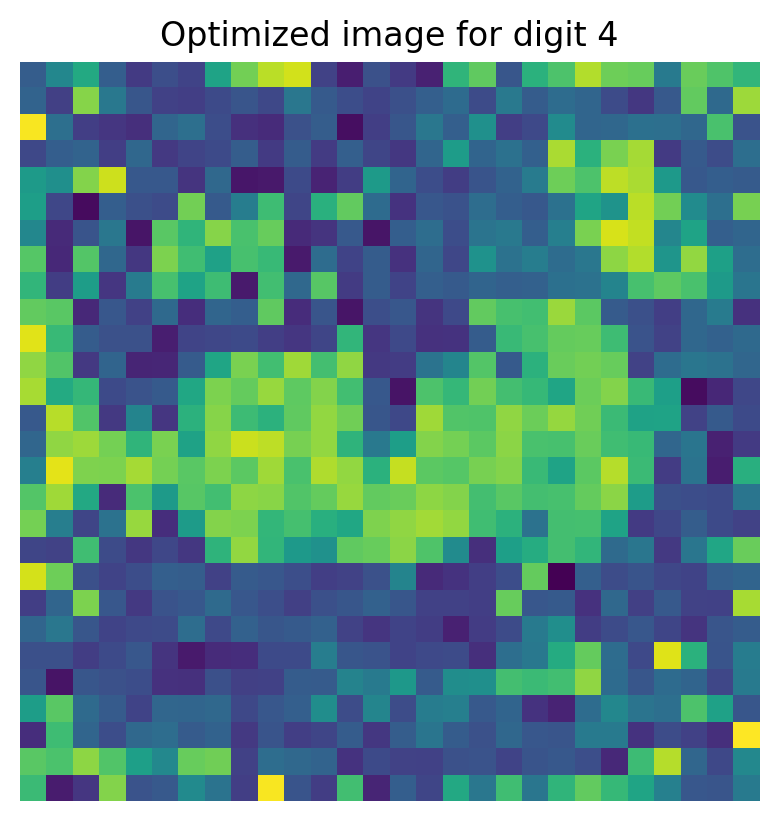

                              Before     After
Probability of being digit 0: 0.0640 -> 0.0001
Probability of being digit 1: 0.0947 -> 0.0001
Probability of being digit 2: 0.0512 -> 0.0000
Probability of being digit 3: 0.0621 -> 0.0005
Probability of being digit 4: 0.1156 -> 0.0000
Probability of being digit 5: 0.2519 -> 0.9971
Probability of being digit 6: 0.0794 -> 0.0010
Probability of being digit 7: 0.0891 -> 0.0000
Probability of being digit 8: 0.0836 -> 0.0008
Probability of being digit 9: 0.1084 -> 0.0003


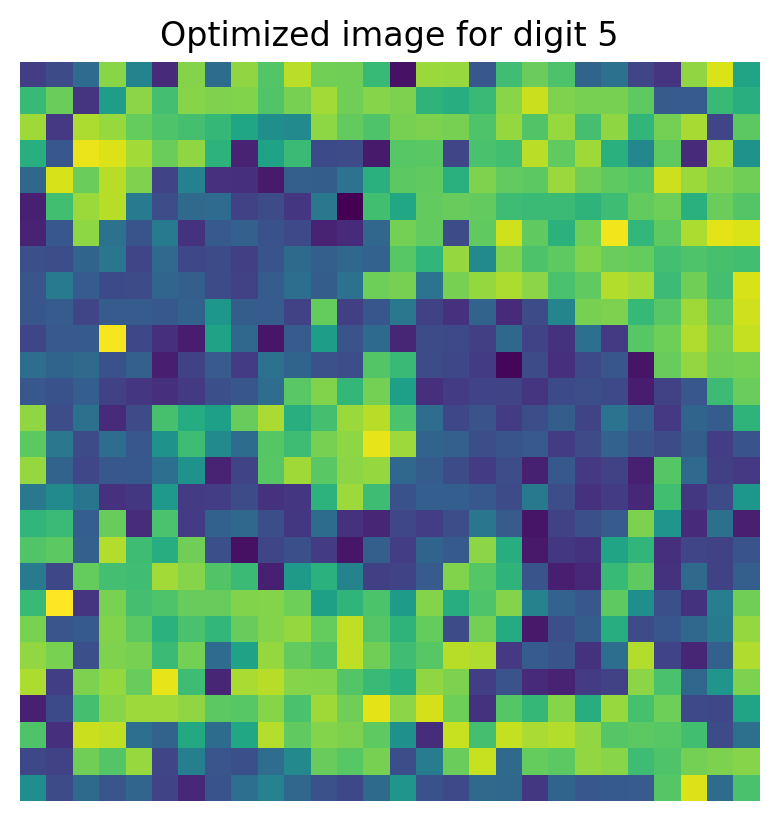

                              Before     After
Probability of being digit 0: 0.0716 -> 0.0004
Probability of being digit 1: 0.0987 -> 0.0015
Probability of being digit 2: 0.0576 -> 0.0029
Probability of being digit 3: 0.0493 -> 0.0000
Probability of being digit 4: 0.1296 -> 0.0010
Probability of being digit 5: 0.2273 -> 0.0016
Probability of being digit 6: 0.1001 -> 0.9911
Probability of being digit 7: 0.0943 -> 0.0001
Probability of being digit 8: 0.0799 -> 0.0015
Probability of being digit 9: 0.0917 -> 0.0000


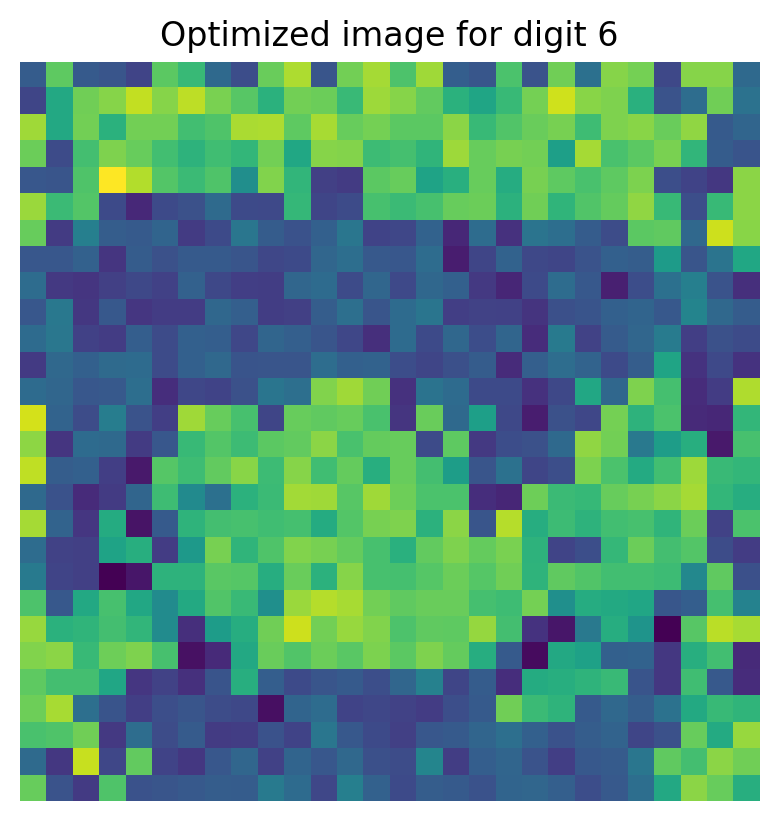

                              Before     After
Probability of being digit 0: 0.0556 -> 0.0000
Probability of being digit 1: 0.1055 -> 0.0002
Probability of being digit 2: 0.0559 -> 0.0002
Probability of being digit 3: 0.0672 -> 0.0005
Probability of being digit 4: 0.1434 -> 0.0006
Probability of being digit 5: 0.2001 -> 0.0001
Probability of being digit 6: 0.0591 -> 0.0000
Probability of being digit 7: 0.1126 -> 0.9865
Probability of being digit 8: 0.0802 -> 0.0000
Probability of being digit 9: 0.1204 -> 0.0118


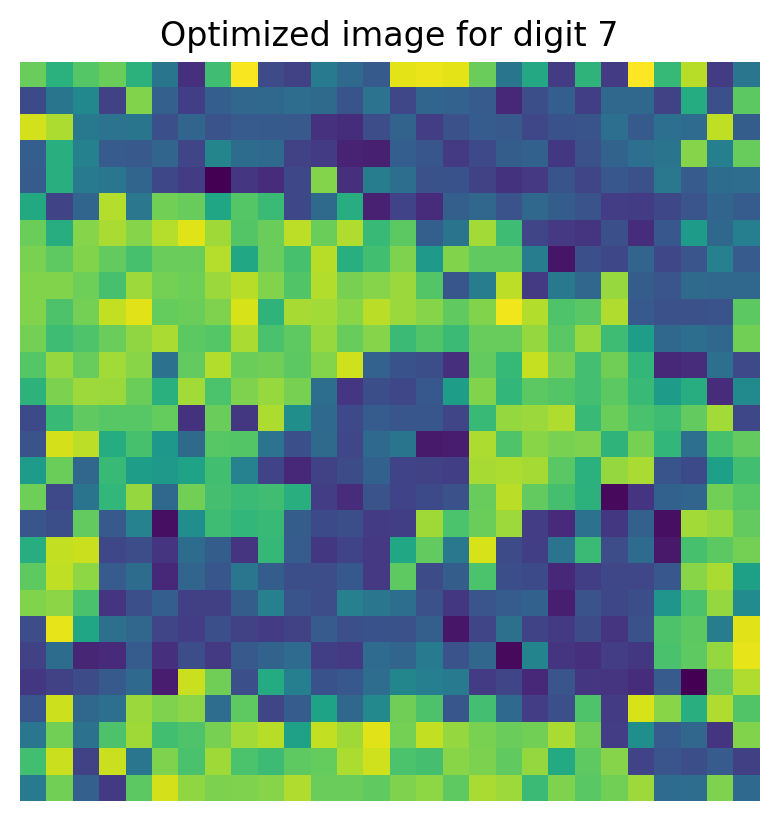

                              Before     After
Probability of being digit 0: 0.0660 -> 0.0004
Probability of being digit 1: 0.1050 -> 0.0043
Probability of being digit 2: 0.0588 -> 0.0020
Probability of being digit 3: 0.0553 -> 0.0009
Probability of being digit 4: 0.1305 -> 0.0017
Probability of being digit 5: 0.2223 -> 0.0037
Probability of being digit 6: 0.0920 -> 0.0030
Probability of being digit 7: 0.0950 -> 0.0008
Probability of being digit 8: 0.0796 -> 0.9825
Probability of being digit 9: 0.0956 -> 0.0007


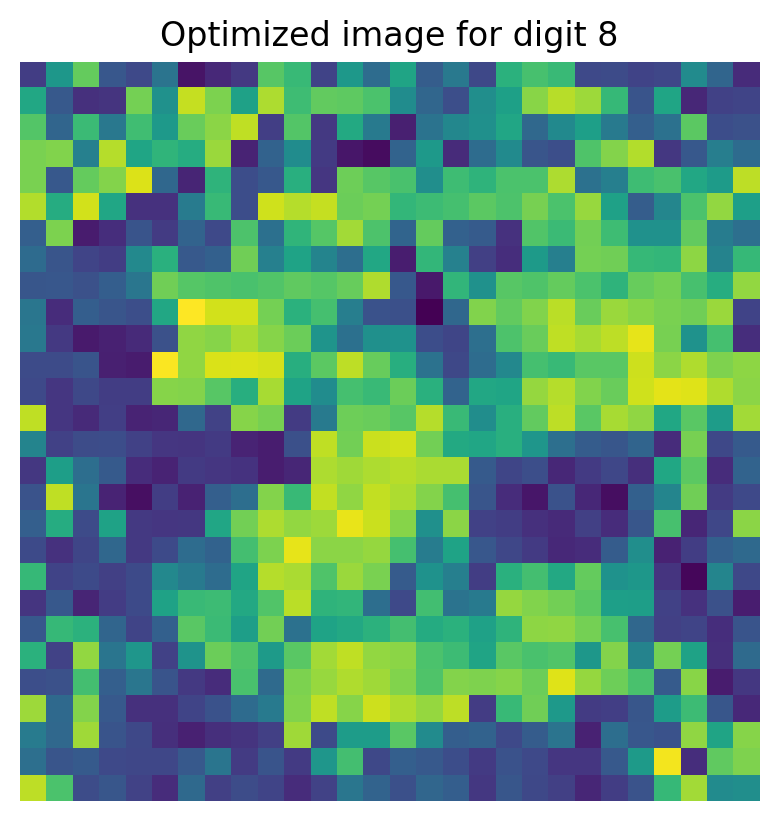

                              Before     After
Probability of being digit 0: 0.0638 -> 0.0000
Probability of being digit 1: 0.1071 -> 0.0000
Probability of being digit 2: 0.0582 -> 0.0000
Probability of being digit 3: 0.0608 -> 0.0003
Probability of being digit 4: 0.1196 -> 0.0005
Probability of being digit 5: 0.2387 -> 0.0003
Probability of being digit 6: 0.0850 -> 0.0000
Probability of being digit 7: 0.0938 -> 0.0019
Probability of being digit 8: 0.0787 -> 0.0000
Probability of being digit 9: 0.0943 -> 0.9969


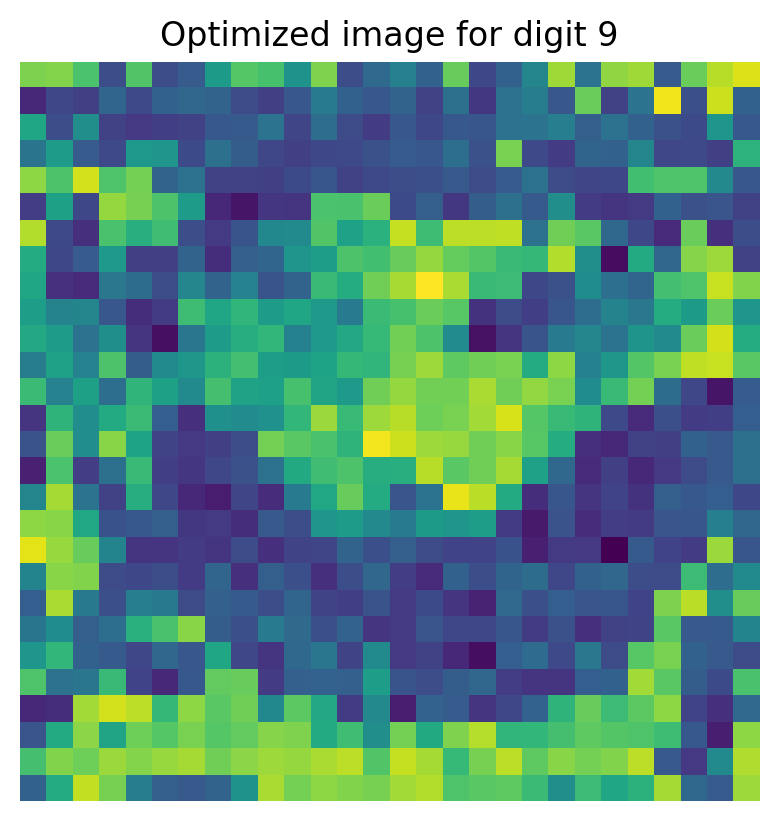

In [125]:
#YOUR CODE HERE

for digit in range(10):
    
    opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop, lr=5e-3, img0=torch.randn(28, 28) * 0.01)
    log_probs_before_train = opt_input.forward()

    probs_before_train = torch.exp(log_probs_before_train)
    
    
    opt_input.trainloop(category=digit, true_prob=torch.tensor([0.9]), sgd_iter=50)
    
    
    log_probs = opt_input.forward()
    probs = torch.exp(log_probs)
    
    print(f"{' ':>25} {'Before':>10} {' ':>3} {'After'}")
    
    for i, (prob_before,prob_after) in enumerate(zip(probs_before_train[0],probs[0])):
        print(f"Probability of being digit {i}: {prob_before.item():.4f} -> {prob_after.item():.4f}")


    optimized_image = opt_input.input.detach().numpy().reshape(28, 28)
    
    plt.imshow(optimized_image, cmap='viridis')
    plt.title(f"Optimized image for digit {digit}")
    plt.axis('off')
    plt.show()